## Benchmark: `to_tensor` versus `to_quimb_tensor`

We start by implementing a class `CircuitGenerator` that generates a ZX circuit in the form of a graph. There are two main methods that we use: the first is to simply call the method `CNOT_HAD_PHASE_circuit` from PyZX library, and the other generates multiple layers, each one consisting of CZ gates and two Z spiders on the first line with random phases. The latter has the effect of producing dense graphs.

In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import quimb.tensor as qtn
import cotengra as ctg
import quimb as qu
import numpy as np
import pyzx as zx
import time, random

class CircuitGenerator:
    def __init__(self, dense: bool = False, qubits: int = 5, depth: int = 10):
        assert qubits > 0, "The number of qubits must be positive."
        assert depth > 0, "The depth must be positive."
        self.__dense = dense
        self.__qubits = qubits
        self.__depth = depth
    
    def __call__(self) -> zx.Graph:
        if self.__dense:
            return self.__dense_graph(qubits = self.__qubits, layers_count = self.__depth)
        else:
            return zx.generate.CNOT_HAD_PHASE_circuit(qubits = self.__qubits,
                                                      depth = self.__depth,
                                                      clifford = False).to_graph()
        
    def __dense_graph(self, qubits, layers_count: int = 10) -> zx.Graph:
        g = zx.Graph()
        inputs = [g.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 0) for i in range(qubits)]
        outputs = [g.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 4 * layers_count + 1) for i in range(qubits)]

        # This local function adds a new layer having a particular shape;
        # we need the previous `qubits` nodes along each line, together with the
        # index `cnt` of the layer we need to construct.
        # It returns the new last vertex on each line.
        def add_layer(prev, cnt):
            # Create the vertices.
            layer = [g.add_vertex(zx.VertexType.Z,
                            qubit = (i + 1) // 2,
                            row = 4 * cnt + (1 if i % 4 < 2 else 2)) for i in range(2 * qubits - 2)]
            # Construct the edges between these `2 * qubits - 2` vertices in a zig-zag shape.
            H, S = zx.EdgeType.HADAMARD, zx.EdgeType.SIMPLE
            for i in range(2 * qubits - 3):
                g.add_edge(g.edge(layer[i], layer[i + 1]), edgetype = H if i % 2 == 0 else S)

            # We collect the first (front) and the last (end) vertex on each of the `qubits` lines.
            front_indices, end_indices = [], []
            front_indices.append(0)
            end_indices.append(0)
            for i in range(1, qubits - 1):
                front_indices.append(2 * i - (i & 1))
                end_indices.append(2 * i - (i + 1 & 1))
            front_indices.append(2 * qubits - 3)
            end_indices.append(2 * qubits - 3)
            
            # Connect the previous layer (or the inputs if this is to be the first one)
            # to the current layer.
            for i in range(qubits):
                g.add_edge(g.edge(prev[i], layer[front_indices[i]]), zx.EdgeType.SIMPLE)

            # Add two randomised red vertices along each wire:
            # Their phases are k * pi / 4 and l * pi / 4, where k and l are independent
            # and uniformly distributed over {0, 1, ..., 7}.
            prev = []
            for i in range(qubits):   
                [k, l] = [g.add_vertex(zx.VertexType.X,
                                       phase = (random.randrange(8)) / 4.,
                                       qubit = i,
                                       row = 4 * cnt + j + 3) for j in range(2)]
                g.add_edge(g.edge(layer[end_indices[i]], k), edgetype = zx.EdgeType.SIMPLE)
                g.add_edge(g.edge(k, l), edgetype = zx.EdgeType.SIMPLE)
                prev.append(l)
            return prev

        # Add all layers whilst updating the prev vertices.
        prev = inputs
        for cnt in range(layers_count):
            prev = add_layer(prev, cnt)

        # Connect the prev vertices with the outputs.
        for i in range(qubits):
            g.add_edge(g.edge(prev[i], outputs[i]), zx.EdgeType.SIMPLE)

        # Set the inputs and outputs
        g.auto_detect_io()
        return g

Now we implement a class `CircuitBenchmark` which performs time profiling of `to_tensor` and `to_quimb_tensor`:
* The constructor sets up fields `n` for the number of circuits to be averaged in one go, `dense` flag which specifies whether dense graphs are to be used or not, and `full_reduce` which specifies whether the function with the same name from `PyZX` ought to be used before converting the diagrams to circuits.
* A private method `run_tensor` is used to generate a circuit, convert it to a graph, use kets 0 as inputs and bras 0 as outputs and calculate the required times for this diagram.
* Another private method `run_tensors` which simply calls `run_tensor` multiple (`n`) times and returns the average times.
* A public method `run_with_qubits` which takes the depth and a range to change the number of qubits in each iteration as inputs; returns two lists containing the times for obtaining the normal and quimb tensor networks, respectively.
* A public method `run_with_depths` which is the same as before but now the number of qubits is fixed and the depth varies.
* A public method `display_plot` which plots tensor and quimb times.
* A static method `get_tabel` which returns a string that tabulates tensor and quimb times.* A public method `display_tabel_and_plot` which both tabulates and plots the same data.

In [2]:
def fourier_transform_2(g):
    from pyzx.utils import EdgeType, VertexType
    del_e = []
    del_v = []
    add_e = []
    types = g.types()
    phases = g.phases()
    es = list(g.edges())
    vs = list(g.vertices())

    for v in vs:
        arity = len(g.neighbors(v))
        if types[v] == VertexType.H_BOX and arity == 2 and phases[v] != 1:
            phase = phases[v]
            v1,v2 = g.neighbors(v)
            c = g.add_vertex(VertexType.Z)
            vh1 = g.add_vertex(VertexType.H_BOX)
            vh2 = g.add_vertex(VertexType.H_BOX)
            ch1 = g.add_vertex(VertexType.H_BOX)
            c2 = g.add_vertex(VertexType.Z)
            ch2 = g.add_vertex(VertexType.H_BOX)
            add_e.append(g.edge(v1, vh1))
            add_e.append(g.edge(v2, vh2))
            add_e.append(g.edge(vh1, c))
            add_e.append(g.edge(vh2, c))
            add_e.append(g.edge(c, ch1))
            add_e.append(g.edge(ch1, c2))
            add_e.append(g.edge(c2, ch2))
            g.set_phase(ch2, phase*(-1/2))
            g.set_phase(v1, phases[v1]+phase*1/2)
            g.set_phase(v2, phases[v2]+phase*1/2)
            g.scalar.add_float(1/2)
            del_v.append(v)
            del_e.append(g.edge(v,v1))
            del_e.append(g.edge(v,v2))


    g.add_edges(add_e)
    g.remove_edges(del_e)
    for v in del_v:
        g.remove_vertex(v)

def fourier_transform_3(g):
    from pyzx.utils import EdgeType, VertexType
    del_e = []
    del_v = []
    add_e = []
    types = g.types()
    phases = g.phases()
    es = list(g.edges())
    vs = list(g.vertices())

    for v in vs:
        arity = len(g.neighbors(v))
        if types[v] == VertexType.H_BOX and arity == 3:
            phase = phases[v]
            v1,v2,v3 = g.neighbors(v)
            c = g.add_vertex(VertexType.Z)
            vh1 = g.add_vertex(VertexType.H_BOX)
            vh2 = g.add_vertex(VertexType.H_BOX)
            vh3 = g.add_vertex(VertexType.H_BOX)
            ch1 = g.add_vertex(VertexType.H_BOX)
            c2 = g.add_vertex(VertexType.Z)
            ch2 = g.add_vertex(VertexType.H_BOX)
            add_e.append(g.edge(v1, vh1))
            add_e.append(g.edge(v2, vh2))
            add_e.append(g.edge(v3, vh3))
            add_e.append(g.edge(vh1, c))
            add_e.append(g.edge(vh2, c))
            add_e.append(g.edge(vh3, c))
            add_e.append(g.edge(c, ch1))
            add_e.append(g.edge(ch1, c2))
            add_e.append(g.edge(c2, ch2))
            vh12 = g.add_vertex(VertexType.H_BOX)
            vh23 = g.add_vertex(VertexType.H_BOX)
            vh31 = g.add_vertex(VertexType.H_BOX)
            add_e.append(g.edge(v1, vh12))
            add_e.append(g.edge(vh12, v2))
            add_e.append(g.edge(v2, vh23))
            add_e.append(g.edge(vh23, v3))
            add_e.append(g.edge(v3, vh31))
            add_e.append(g.edge(vh31, v1))
            g.set_phase(ch2, phase*(1/4) )
            g.set_phase(vh12, phase*(1/2))
            g.set_phase(vh23, phase*(1/2) )
            g.set_phase(vh31, phase*(1/2) )
            g.set_phase(v1, phases[v1]-phase*1/4)
            g.set_phase(v2, phases[v2]-phase*1/4)
            g.set_phase(v3, phases[v3]-phase*1/4)
            g.scalar.add_float(1/2)
            del_v.append(v)
            del_e.append(g.edge(v,v1))
            del_e.append(g.edge(v,v2))
            del_e.append(g.edge(v,v3))


    g.add_edges(add_e)
    g.remove_edges(del_e)
    for v in del_v:
        g.remove_vertex(v)

In [10]:
class CircuitBenchmark():
    def __init__(self, n: int, dense: bool = False, full_reduce: bool = False, estimate: bool = False):
        self.__n = n
        self.__dense = dense
        self.__full_reduce = full_reduce
        self.__estimate = estimate
    
    def run_with_qubits(self, depth, qubits_range):
        tensor_times, quimb_times = [], []
        self.__depth = depth
        for qubits in qubits_range:
            self.__qubits = qubits
            self.__generator = CircuitGenerator(self.__dense, qubits, depth)
            tensor_time, quimb_time = self.__run_tensors()
            tensor_times.append(tensor_time)
            quimb_times.append(quimb_time)
        return tensor_times, quimb_times

    def run_with_depths(self, qubits, depth_range):
        tensor_times, quimb_times = [], []
        self.__qubits = qubits
        for depth in depth_range:
            self.__depth = depth
            self.__generator = CircuitGenerator(self.__dense, qubits, depth)
            tensor_time, quimb_time = self.__run_tensors()
            tensor_times.append(tensor_time)
            quimb_times.append(quimb_time)
            print(f"Depth: {depth}, qubits: {qubits}, tensor time: {tensor_time}, quimb time: {quimb_time}")
        return tensor_times, quimb_times
    
    def __contract_quimb(self, g):
        tensor = zx.to_quimb_tensor(g)
        tensor.full_simplify_('ADCSR',atol=1e-18,output_inds=())
        # print(f'Quimb: #Tensors={tensor.num_tensors}, #Indices={tensor.num_indices}')
        tensor = tensor.contract(output_inds = (),backend='jax')
        return tensor
   
    def __optimize_graph(self, g):
        zx.full_reduce(g)
        zx.hsimplify.new_simp(g,quiet=False)
        fourier_transform_3(g)
        zx.hsimplify.par_hbox_simp(g,quiet=True)
        fourier_transform_2(g)
        
        return g
    
    def __run_tensor(self):
        # Generate a circuit and convert it to a graph object
        g = self.__generator()
        rand_state = "".join(str(e) for e in [random.randrange(2) for _ in range(self.__qubits)])
        rand_effect = "".join(str(e) for e in [random.randrange(2) for _ in range(self.__qubits)])
        g.apply_state("0"*self.__qubits)  # use kets 0 as inputs
        g.apply_effect("0"*self.__qubits) # use bras 0 as outputs
        zx.to_gh(g)                         # get rid of red spiders
        # if self.__full_reduce:
        #     zx.full_reduce(g)
        
        # Profiling Quimb
        t = time.time()
        quimb_tn = self.__contract_quimb(g)
        quimb_time = time.time() - t

        

        # Profiling Quimb+ZX
        t = time.time()
        g = self.__optimize_graph(g)
        tensor = self.__contract_quimb(g)
        tensor_time = time.time() - t
        
        # Assert correctness and update the list fields.
        assert (abs(abs(quimb_tn)-abs(tensor))/abs(tensor))< 1e-4, f"quimb+zx (tensor) and quimb (quimb_tn) don't exhibit the same result, \
                                                 quimb_tn = {abs(quimb_tn)} tensor = {abs(tensor)} diff={(abs(abs(quimb_tn)-abs(tensor))/abs(tensor))}"
        self.__tensor_times.append(tensor_time)
        self.__quimb_times.append(quimb_time)
    
    def __run_tensors(self):
        self.__tensor_times = []
        self.__quimb_times = []
        for _ in range(self.__n):
            self.__run_tensor()
        return (np.mean(self.__tensor_times), np.mean(self.__quimb_times))
    
    def display_plot(self, tensor_times, quimb_times, range, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("qubits", "depth", self.__depth) if has_qubits else \
                                          ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        ax.plot(range, tensor_times, label = "to_tensor")
        ax.plot(range, quimb_times, label = "to_quimb_tensor")
        ax.set_xlabel(var_type)
        ax.set_ylabel("time (s)")
        ax.set_title(
            "From {} to {} {}, fixed {} of {}".format(
                range[0], range[-1], var_type, fixed_type, fixed_quant
            )
        )
        ax.legend()
    
    @staticmethod
    def get_table(var, range_var, tensor_times, quimb_times):
        def list_to_row(name, elems):
            s = name.ljust(15)
            is_first = True
            for x in elems:
                if is_first:
                    is_first = False
                else:
                    s += " | "
                s += str(x).rjust(7) if isinstance(x, int) else "{:.3f}".format(x).rjust(7)
            s += '\n'
            return s
        
        s = list_to_row(f"{var}:", range_var)
        s += list_to_row("Tensor times:", tensor_times)
        s += list_to_row("Quimb times:", quimb_times)
        return s
    
    def display_tabel_and_plot(self, tensor_times, quimb_times, range, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("Qubits", "depth", self.__depth) if has_qubits else \
                                            ("Depth", "qubits", self.__qubits)
        str_full_reduce = " (with full_reduce = True)" if self.__full_reduce else ""
        print("For {} {}{}:\n".format(fixed_quant, fixed_type, str_full_reduce))
        print(CircuitBenchmark.get_table(var_type, range, tensor_times, quimb_times))
        self.display_plot(tensor_times, quimb_times, range, has_qubits)
    
    def test(self, has_qubits: bool, fixed_quant: int, range, with_table: bool = False):
        tensor_times, quimb_times = self.run_with_qubits(fixed_quant, range) if has_qubits \
            else self.run_with_depths(fixed_quant, range)
        if with_table:
            self.display_tabel_and_plot(tensor_times, quimb_times, range, has_qubits)
        else:
            self.display_plot(tensor_times, quimb_times, range, has_qubits)

We now compare `to_tensor` against `to_quimb_tensor` by fixing the depth and varying the number of qubits, while `dense` and `full_reduce` are, by default, `False`:

In [14]:
cb = CircuitBenchmark(3)
cb.test(has_qubits = True, fixed_quant = 40, range = range(1, 41))

The time for transforming the circuit into a normal tensor network and contracting it takes time that increases exponentially with the number of qubits when the depth is fixed, whereas the time for building and contracting the corresponding Quimb tensor network remains (roughly) constant.

Now we fix the number of qubits and change the depth:

Depth: 2, qubits: 25, tensor time: 0.0033687750498453775, quimb time: 0.015575488408406576
Depth: 3, qubits: 25, tensor time: 0.001844167709350586, quimb time: 0.009142716725667318
Depth: 4, qubits: 25, tensor time: 0.002669254938761393, quimb time: 0.011995792388916016
Depth: 5, qubits: 25, tensor time: 0.001861572265625, quimb time: 0.009457588195800781
Depth: 6, qubits: 25, tensor time: 0.002104600270589193, quimb time: 0.011487801869710287
Depth: 7, qubits: 25, tensor time: 0.0028319358825683594, quimb time: 0.019058863321940105
Depth: 8, qubits: 25, tensor time: 0.0038277308146158853, quimb time: 0.01596975326538086
Depth: 9, qubits: 25, tensor time: 0.0045880476633707685, quimb time: 0.01081236203511556
Depth: 10, qubits: 25, tensor time: 0.0026282469431559243, quimb time: 0.015573740005493164
Depth: 11, qubits: 25, tensor time: 0.0036624272664388022, quimb time: 0.015773455301920574
Depth: 12, qubits: 25, tensor time: 0.004152695337931315, quimb time: 0.012972116470336914
Depth:

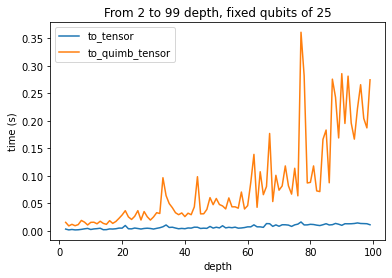

In [12]:
cb.test(has_qubits = False, fixed_quant = 25, range = range(2, 100))

Interestingly, as the depth increases and the number of qubits is fixed, both tasks seem to perform the same up to a constant factor; the curves are roughly linear. Quimb definitely has the better constant.

Now we repeat the same experiments but with `full_reduce = True`:

For 20 depth (with full_reduce = True):

Qubits:              2 |       3 |       4 |       5 |       6 |       7 |       8 |       9 |      10 |      11 |      12 |      13 |      14 |      15
Tensor times:    0.000 |   0.000 |   0.000 |   0.000 |   0.001 |   0.001 |   0.001 |   0.001 |   0.001 |   0.001 |   0.001 |   0.000 |   0.001 |   0.002
Quimb times:     0.016 |   0.015 |   0.015 |   0.015 |   0.039 |   0.022 |   0.031 |   0.171 |   0.039 |   0.033 |   0.035 |   0.033 |   0.032 |   0.055



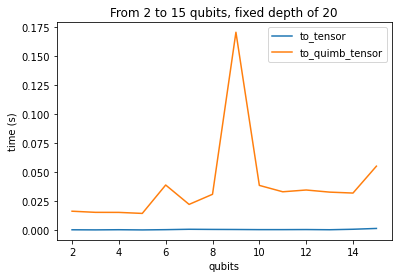

In [18]:
cb = CircuitBenchmark(5, full_reduce = True)
cb.test(has_qubits = True, fixed_quant = 20, range = range(2, 16), with_table = True)

Now the times are negligible, graphs are reduced to simple scalars.

(When the depth is fixed, there are certain situations when the normal method is better, but overall Quimb is better because, as the the number of qubits gets higher, not only it firmly outperforms, but some circuits take exponentially more time to be contracted with `to_tensor`, which leads to spikes in the graph. This is mostly likely due to the fact that `full_reduce` can introduce spiders with many wires, which in turn results in an exponential time increase with `to_tensor`.)

Depth: 2, qubits: 25, tensor time: 0.00043759346008300783, quimb time: 0.013385772705078125
Depth: 3, qubits: 25, tensor time: 0.00042972564697265627, quimb time: 0.010098075866699219
Depth: 4, qubits: 25, tensor time: 0.00048470497131347656, quimb time: 0.010703611373901366
Depth: 5, qubits: 25, tensor time: 0.0006260871887207031, quimb time: 0.010567903518676758
Depth: 6, qubits: 25, tensor time: 0.000542593002319336, quimb time: 0.015980958938598633
Depth: 7, qubits: 25, tensor time: 0.000606536865234375, quimb time: 0.015143585205078126
Depth: 8, qubits: 25, tensor time: 0.0006822586059570312, quimb time: 0.017254734039306642
Depth: 9, qubits: 25, tensor time: 0.0008592605590820312, quimb time: 0.021796131134033205
Depth: 10, qubits: 25, tensor time: 0.0009118080139160156, quimb time: 0.018642997741699217
Depth: 11, qubits: 25, tensor time: 0.00039424896240234373, quimb time: 0.01669340133666992
Depth: 12, qubits: 25, tensor time: 0.0004608631134033203, quimb time: 0.02225437164306

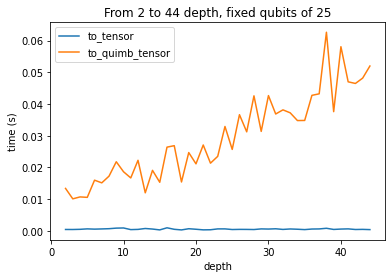

In [19]:
cb.test(has_qubits = False, fixed_quant = 25, range = range(2, 45))

Simple scalars here as well.

(As with `full_reduce = False`, we got two functions that grow almost the same at the beginning, up to a constant factor, with Quimb having the better constant; then `to_tensor` time increases exponentially due to more frequent spikes which occur because of spiders with many wires.)

Now we do some experiments with dense graphs:

Depth: 1, qubits: 10, tensor time: 0.0009434223175048828, quimb time: 0.04720759391784668
Depth: 2, qubits: 10, tensor time: 0.005797863006591797, quimb time: 0.06462907791137695
Depth: 3, qubits: 10, tensor time: 0.005478858947753906, quimb time: 0.07552862167358398
Depth: 4, qubits: 10, tensor time: 0.261458158493042, quimb time: 0.09850049018859863
Depth: 5, qubits: 10, tensor time: 0.27188873291015625, quimb time: 1.0843260288238525
Depth: 6, qubits: 10, tensor time: 1.4522957801818848, quimb time: 1.0503599643707275


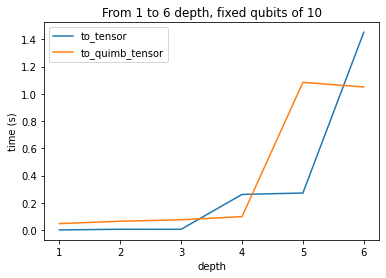

In [5]:
cb = CircuitBenchmark(1, dense = True)
cb.test(has_qubits = False, fixed_quant = 10, range = range(1, 7))

When the number of qubits is fixed, both curves increase linearly but, perhaps surprisingly, `to_tensor` has the better constant.

Depth: 1, qubits: 6, tensor time: 0.0007488727569580078, quimb time: 0.011504411697387695
Depth: 2, qubits: 6, tensor time: 0.01695108413696289, quimb time: 0.025118303298950196
Depth: 3, qubits: 6, tensor time: 0.08673920631408691, quimb time: 0.21927385330200194
Depth: 4, qubits: 6, tensor time: 0.03528971672058105, quimb time: 0.14716391563415526
Depth: 5, qubits: 6, tensor time: 1.0941290855407715, quimb time: 0.44072208404541013
Depth: 6, qubits: 6, tensor time: 0.5680027008056641, quimb time: 0.6262689590454101
Depth: 7, qubits: 6, tensor time: 0.27994332313537595, quimb time: 0.8385547161102295
Depth: 8, qubits: 6, tensor time: 0.359053373336792, quimb time: 1.0272217750549317
Depth: 9, qubits: 6, tensor time: 1.047943353652954, quimb time: 1.223802137374878
Depth: 10, qubits: 6, tensor time: 1.440328598022461, quimb time: 1.4912693500518799
Depth: 11, qubits: 6, tensor time: 1.5956650733947755, quimb time: 1.8111902236938477


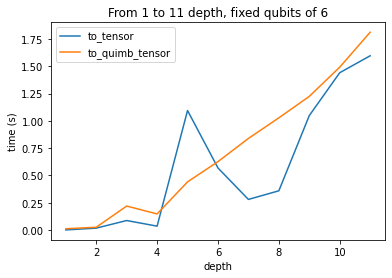

In [5]:
cb = CircuitBenchmark(n = 5, dense = True, full_reduce = True)
cb.test(has_qubits = False, fixed_quant = 6, range = range(1, 12))

When `full_reduce` comes into play, there are two possible scenarios: either the graph is simplied enough so that we end up with a small graph and `to_tensor` slightly outperforms `to_quimb_tensor` because the former employs a numerical order path whereas the latter needs to find a path before doing the contraction, or the simplification leads to a complex graph where there are spiders with many wires and that leads to an explosion (spike) in time for `to_tensor` which is not the case for `to_quimb_tensor`.

### Comparing different contraction path finder strategies
Now we will look at different contraction strategies that Quimb can use when performing the contraction. It is very important to note that finding the contraction path and actually performing the contraction are done separately and there is a performance trade off between them.

We employ some Hyper optimizers, namely **Greedy** (an agglomerative approach), **KaHyPar** (a divisive approach, i.e. building the contraction tree from the top down), and **Optimal** (an approach that finds the optimal contraction path using dynamic programming) as per [this](https://quantum-journal.org/papers/q-2021-03-15-410/) paper. Unfortunately **Betweenness** (community detection) can't be used because it only works with simple graphs, i.e. without hyperedges, which is not the case here.

The class `QuimbStrategies` that we use for this benchmark is very similar to the one above, having methods with the same labels.

In [6]:
class QuimbStrategies:
    def __init__(self, n: int, strategies, dense: bool = False, full_reduce: bool = False):
        self.__n = n
        self.__strategies = strategies
        self.__dense = dense
        self.__full_reduce = full_reduce
    
    def run_with_qubits(self, depth, qubits_range):
        times = [[] for _ in range(1 + len(self.__strategies))]
        self.__depth = depth
        
        for qubits in qubits_range:
            self.__qubits = qubits
            self.__generator = CircuitGenerator(self.__dense, qubits, depth)
            methods_times = self.__run_tensors()
            for i, time in enumerate(methods_times):
                times[i].append(time)
        return times
    
    def run_with_depths(self, qubits, depth_range):
        times = [[] for _ in range(1 + len(self.__strategies))]
        self.__qubits = qubits
        
        for depth in depth_range:
            self.__depth = depth
            self.__generator = CircuitGenerator(self.__dense, qubits, depth)
            methods_times = self.__run_tensors()
            for i, time in enumerate(methods_times):
                times[i].append(time)
        return times
    
    def __run_tensor(self):
        g = self.__generator()
        g.apply_state("0" * self.__qubits)
        g.apply_effect("0" * self.__qubits)
        zx.to_gh(g)
        # if self.__full_reduce:
        #     zx.full_reduce(g)
        zx.full_reduce(g)
        zx.hsimplify.new_simp(g,quiet=True)
        fourier_transform_3(g)
        zx.hsimplify.par_hbox_simp(g,quiet=True)
        fourier_transform_2(g)
        t = time.time()
        tensor = zx.to_quimb_tensor(g).contract(output_inds = ())
        self.__times[0].append(time.time() - t)
        
        for i, method in enumerate(self.__strategies):
            t = time.time()
            tn = zx.to_quimb_tensor(g)
            tn.full_simplify_('ADCRS', output_inds = (), equalize_norms = True)
            tn.contract(optimize = method, output_inds = ())
            self.__times[i + 1].append(time.time() - t)
    
    def __run_tensors(self):
        self.__times = [[] for _ in range(1 + len(self.__strategies))]
        for _ in range(self.__n):
            self.__run_tensor()
        return [np.mean(collection_of_times) for collection_of_times in self.__times]
    
    def display_plot(self, times, range, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("qubits", "depth", self.__depth) if has_qubits else \
                                            ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        for i, method_times in enumerate(times):
            ax.plot(range, method_times, '--', label = "basic" if i == 0 else self.__strategies[i - 1])
        ax.set_xlabel(var_type)
        ax.set_ylabel("time (s)")
        ax.set_title(
            "From {} to {} {}, fixed {} of {}".format(
                range[0], range[-1], var_type, fixed_type, fixed_quant
            )
        )
        ax.legend()
    
    def test(self, has_qubits: bool, fixed_quant: int, range):
        times = self.run_with_qubits(fixed_quant, range) if has_qubits \
                    else self.run_with_depths(fixed_quant, range)
        self.display_plot(times, range, has_qubits)

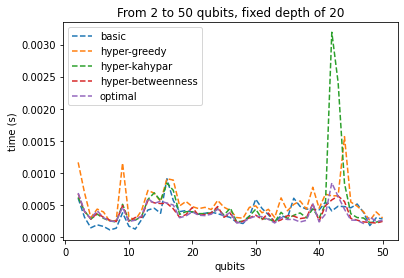

In [12]:
qs = QuimbStrategies(5,  ["hyper-greedy", "hyper-kahypar", "hyper-betweenness", "optimal"])
qs.test(has_qubits = True, fixed_quant = 20, range = range(2, 51))

We conclude that the hyper optimizers perform well and almost the same when the number of qubits varies, but are worse than the basic greedy path optimizer because of the time needed to find the paths.

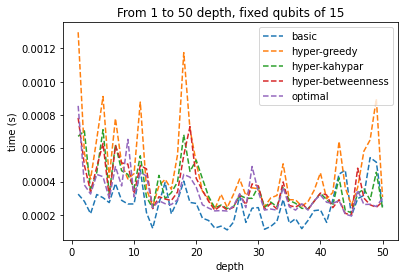

In [13]:
qs = QuimbStrategies(3, ["hyper-greedy", "hyper-kahypar", "hyper-betweenness", "optimal"])
qs.test(has_qubits = False, fixed_quant = 15, range = range(1, 51))

When the depth varies and the number of qubits is fixed, the same behaviour can be observed as when comparing `to_tensor` against `to_quimb_tensor`. The graphs increase linearly; the slope for the custom methods are (almost) identical and worse than the one for the basic optimizer. Ocasional spikes occur for all methods.

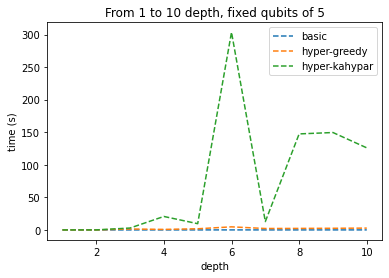

In [14]:
qs = QuimbStrategies(5, ["hyper-greedy", "hyper-kahypar"], dense = True)
qs.test(has_qubits = False, fixed_quant = 5, range = range(1, 11))

A rather striking fact can be observed when dense circuits are used without `full_reduce`: the custom optimisers perform poorly on dense circuits, i.e. time increases exponentially with the depth, whilst the basic one is able to mantain a linear increase with respect to the depth.

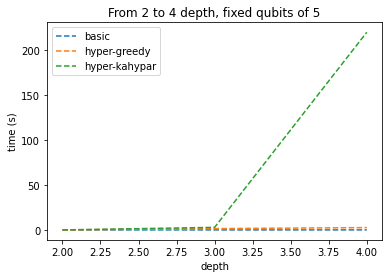

In [15]:
qs = QuimbStrategies(2, 
                     ["hyper-greedy", "hyper-kahypar"], 
                     dense = True, 
                     full_reduce = True)
qs.test(has_qubits = False, fixed_quant = 5, range = range(2, 5))

When performing `full_reduce` before transforming the diagram into a tensor network, the same behaviour can be observed, even more extreme: **Hyper-KaHyPar** method takes more than 5 seconds to process a dense graph with five qubits and four layers.

This effect of increasing the time when `full_reduce` is performed on dense graphs is due to obtaining small but very connected graphs where the basic approach performs better by not having to search for multiple paths and choosing the best one like the other approaches do.